# What to expect from this notebook<a id="top"></a>

- an example of using of satellites to detect changes in plant life.
- very basic xarray manipulations
- removing clouds and patching scanlines
- building a composite image

<br>  

# Algorithmic process  

- [get the maximum extents of the datacube](#extents)
- [define extents you require that fall within the maximum extents](#define_extents)
    [* selecting too much can make the acquisition process slow ]
- [filter out cloud data and scan lines](#clean_mask)
- [plot a map of a specific acquisition NDVI](#plot_maps)
- [plot a time series analysis](#time_series)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

In [17]:
%matplotlib inline

#Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

In [2]:
#Get all the current datacube products
products = dc.list_products()

#List the LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                           name
id                                          
8   LANDSAT_7       ls7_collections_sr_scene
70  LANDSAT_7  ls7_collections_sr_scene_lean
19  LANDSAT_7        ls7_ledaps_amazon_river
20  LANDSAT_7          ls7_ledaps_bangladesh
35  LANDSAT_7     ls7_ledaps_bangladesh_bari
36  LANDSAT_7             ls7_ledaps_caqueta
21  LANDSAT_7            ls7_ledaps_colombia
22  LANDSAT_7               ls7_ledaps_ghana
23  LANDSAT_7               ls7_ledaps_kenya
41  LANDSAT_7        ls7_ledaps_lake_baringo
24  LANDSAT_7      ls7_ledaps_lake_chad_full
25  LANDSAT_7        ls7_ledaps_lake_cortijo
26  LANDSAT_7      ls7_ledaps_menindee_lakes
27  LANDSAT_7          ls7_ledaps_meta_river
62  LANDSAT_7              ls7_ledaps_mexico
28  LANDSAT_7     ls7_ledaps_salgar_colombia
72  LANDSAT_7          ls7_ledaps_sanagustin
63  LANDSAT_7               ls7_ledaps_scene
29  LANDSAT_7                ls7_ledaps_togo
30  LANDSAT_7               ls7_ledaps_tonga
31  LANDSA

In [3]:
#This are the platform (satellite) and product (datacube set) used for this demonstration
platform = "LANDSAT_7"
product = "ls7_ledaps_kenya"

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Getting the Extents of the Cube</a>

In [4]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product)

#store the latitudinal and longitudinal extents
lat, lon = products.resolution[products.platform == platform].any()

from utils.data_cube_utilities.dc_display_map import display_map

#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)
max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3) 

In [5]:
from dc_notebook_utilities import generate_metadata_report

# Display the ranges of the datacube in a table
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

'Basemap' was not found in 'mpl_toolkits.basemap'.  It is likely that 'mpl_toolkits.basemap' is not present


,Min,Max,Resolution
Date:,2005-1-8,2016-12-24,
Longitude:,34.655,36.899,0.000269995
Latitude:,-0.942,0.95,-0.000271302


## <a id="define_extents">Defining the Extents of Data to Retrieve from the Cube</a>

In [6]:
min_lon = 35.5
max_lon = 35.7
min_lat = 0.5
max_lat = 0.7
from datetime import datetime
start_date      = datetime.strptime('2005-01-08', '%Y-%m-%d')
end_date        = datetime.strptime('2005-12-31', '%Y-%m-%d')
time_extents = (start_date, end_date)
landsat_dataset = dc.load(lat = (min_lat, max_lat),
                          lon = (min_lon, max_lon),
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']) 

In [7]:
def NDVI(dataset):
    return (dataset.nir - dataset.red) / (dataset.nir + dataset.red)
ndvi = NDVI(landsat_dataset)

In [8]:
acquisition_dates = np.array([pd.to_datetime(str(time)).strftime('%Y-%m-%d') for time in ndvi.time.values])
print(acquisition_dates)

['2005-01-08' '2005-01-24' '2005-02-25' '2005-03-13' '2005-03-29'
 '2005-04-14' '2005-05-16' '2005-06-01' '2005-06-17' '2005-07-03'
 '2005-08-04' '2005-09-05' '2005-09-21' '2005-10-07']


In [166]:
acquisition = '2005-01-08' # The date of acquisition for plotting NDVI.
acquisition_index = np.argmax(acquisition_dates == acquisition)

True color plot

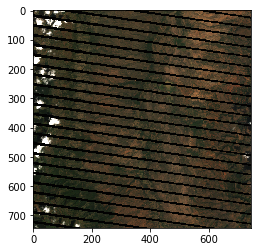

In [167]:
from dc_notebook_utilities import rgb
rgb(landsat_dataset, at_index=acquisition_index, bands=['red', 'green', 'blue'])

False color plot

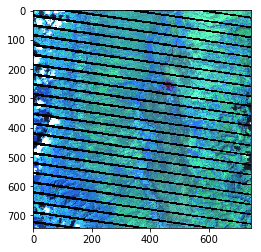

In [168]:
rgb(landsat_dataset, at_index=acquisition_index, bands=['green', 'swir1', 'nir'])

## <a id="plot_maps">Plotting NDVI with Gradients</a>

In [169]:
from utils.data_cube_utilities.dc_display_map import display_map
ndvi_plotting_data = ndvi.isel(time=acquisition_index)

In [175]:
import matplotlib.colors as colors
def plot_threshold(ds, band_name=None, vmin=None, vmax=None, log_scaled = False, 
                   cmap = None, cmap_name = 'Greys'):
    # Threshold is applied to original data, not log scaled data(if you haven't scaled already)
    if band_name is not None:
        _range = "Full {} range: {}-{}".format(band_name, ds.min().values,ds.max().values)
    else: 
        _range = "Full range: {}-{}".format(ds.min().values,ds.max().values)
    
    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)
    
    selection = ds[band_name] if band_name is not None else ds
    
    if cmap is None:
        cmap = matplotlib.cm.get_cmap(cmap_name)
    
    cmap.set_over('r')
    cmap.set_under('g')

    plt.figure(figsize = figure_ratio(ds))
    
    selection = 10*np.log10(selection) if log_scaled == True else selection
    
    ds  = 10*np.log10(ds) if log_scaled else selection
    vmin = np.float32(ds.min().values)
    vmin = 10*np.log10(vmin)      if log_scaled and vmin is not None else vmin
    vmax = np.float32(ds.max().values)
    vmax = 10*np.log10(vmax)     if log_scaled and vmax is not None else vmax
    
    selection.plot(cmap=cmap, vmax=vmax, vmin=vmin)    
    plt.figtext(0.7,0,_range, horizontalalignment = "center")

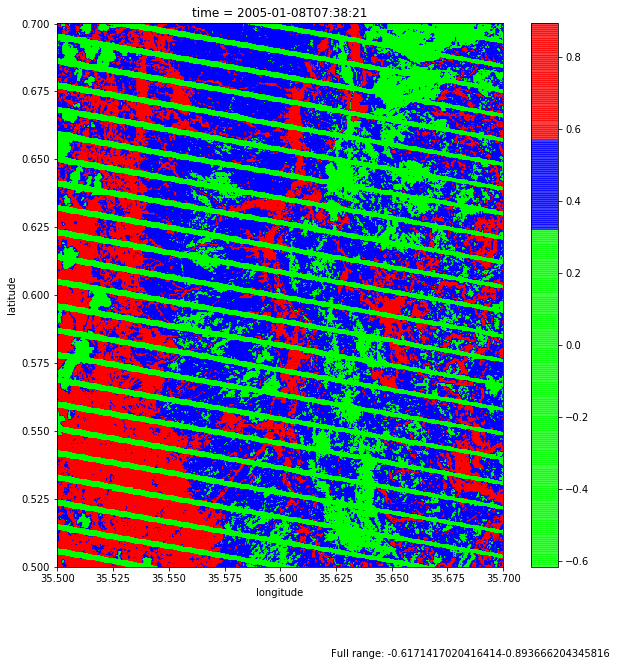

In [176]:
from matplotlib.colors import LinearSegmentedColormap
th = [0.62, 0.95] # Color thresholds
cdict = {'red':   [(0.0, 0.0, 0.0),
                   ((th[0]+th[1])/2, 0.0, 1.0),
                   (th[1], 1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (th[0], 1.0, 0.0),
                   ((th[0]+th[1])/2, 0.0, 0.0),
                   (1.0, 0.0, 0.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (th[0], 0.0, 1.0),
                   ((th[0]+th[1])/2, 1.0, 0.0),
                   (th[1], 0.0, 0.0),
                   (1.0, 0.0, 0.0)],
        'alpha': [(0.0, 0.75, 0.75),
                  (1.0, 0.75, 0.75)]}
cmap = LinearSegmentedColormap('my_cmap', cdict)
plot_threshold(ndvi_plotting_data, cmap=cmap)

## <a id="time_series">Plotting average NDVI over time</a>

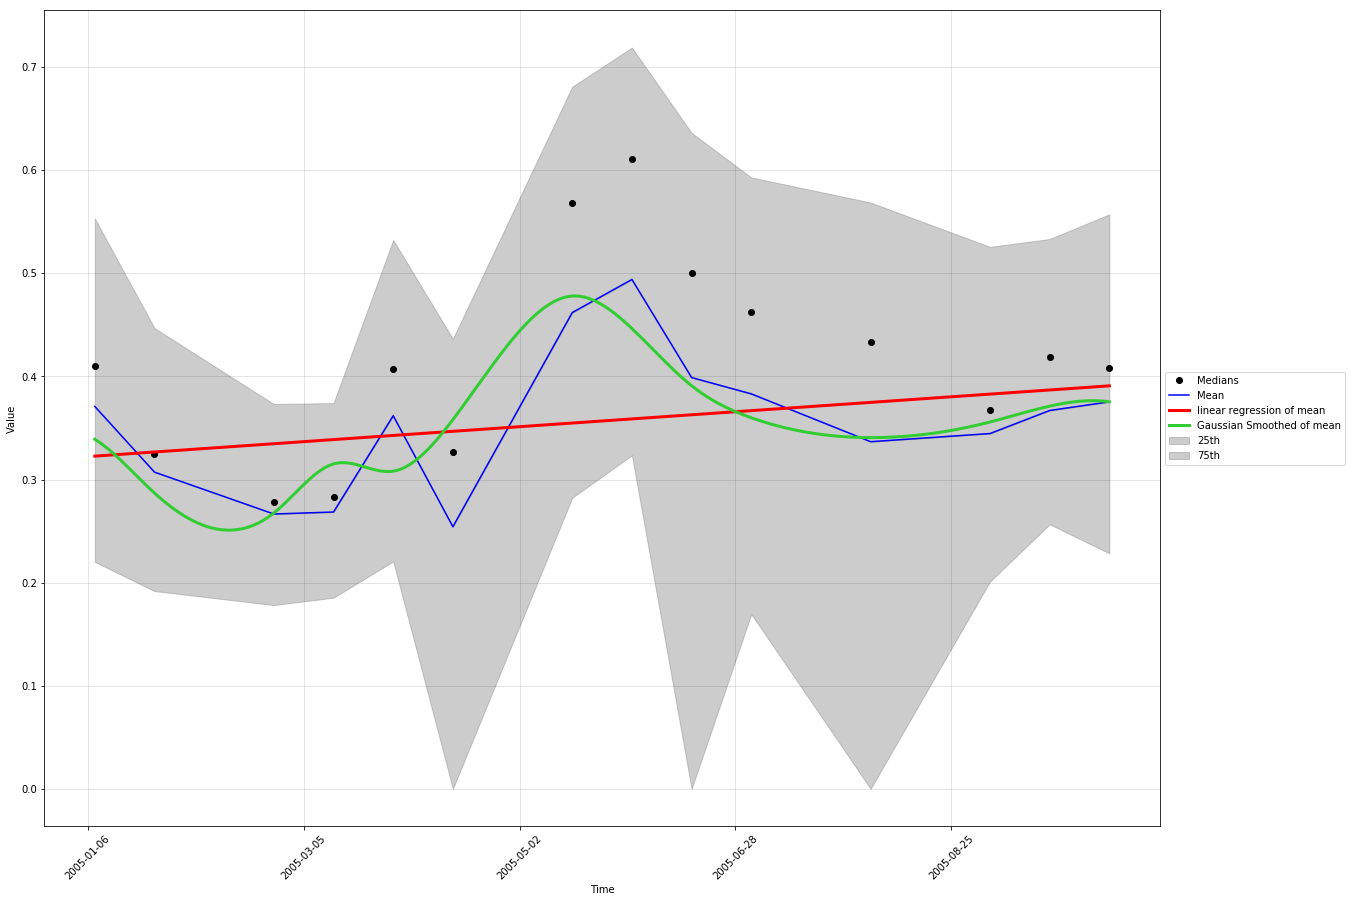

In [178]:
import utils.data_cube_utilities.plotter_utils as plotter
plotter.plot_band(landsat_dataset, ndvi)